# Larva tracking

Google Colaboratory or Colab is a hosted Jupyter Notebook service that requires no setup to use and provides free access to computing resources, including GPUs and TPUs. Colab is especially well suited to machine learning, data science, and education.

If you haven't used Colab, there is a helpful introduction here:

https://colab.research.google.com/github/anthony-agbay/python-resource-guide/blob/master/notebooks/intro-notebooks.ipynb

To track the larvae using the pipeline, follow the sections in order:
0. Select GPU
1. Set-up
2. Set-up Google Drive and main directory
3. Calibration
4. Manual pipeline (single video) or 5. Automated pipeline (single video) or 6. Automated pipeline (directory of videos)

## 0 Select GPU


Follow the steps to select a GPU. **L4 GPU** (cost effective) or **A100** (fastest) is recommended.

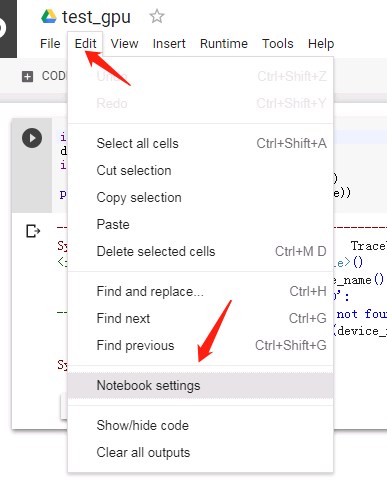

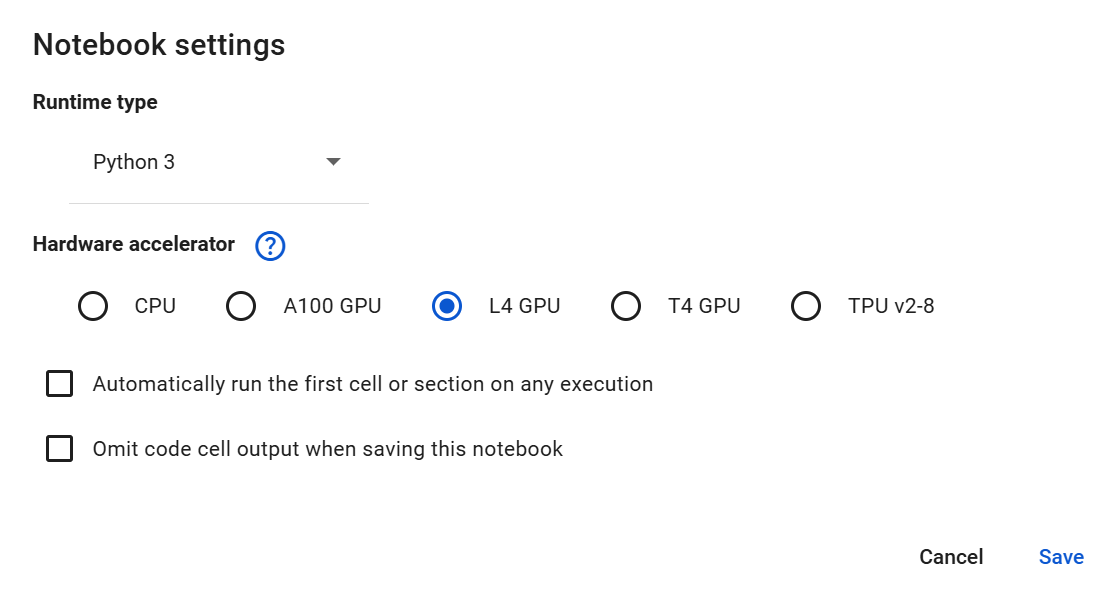

## 1 Set-up

This section sets up the environment, libraries and functions that are needed. It doesn't need human interaction so we can collapse the whole section and run.

### 1.1 Environment Set-up

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install -q opencv-python matplotlib ultralytics ffmpeg-python ipympl shapely
    !{sys.executable} -m pip install -q 'git+https://github.com/short0/sam2.git'

    !mkdir -p ./sam2_checkpoints/
    !wget -q -P ./sam2_checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

    !mkdir -p ./yolov8_checkpoints/
    !gdown -q --fuzzy -O ./yolov8_checkpoints/best.pt https://drive.google.com/file/d/1qlITJxJwaoaXcwFuUL8eJXqGoPTGpw6k/view?usp=sharing

### 1.2 Set-up

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import ffmpeg
import os
import torch
import numpy as np
from tqdm import tqdm
from shapely.geometry import Polygon
from scipy.spatial import distance
import pandas as pd
from scipy import stats
import copy
from collections import defaultdict
from ultralytics.utils.plotting import Annotator, colors
from ultralytics.engine.results import Masks, Boxes
import shutil
import pickle
import sam2
from sam2.build_sam import build_sam2_video_predictor

In [ ]:
from sam2.utils.utils import \
    get_video_info, \
    get_larva_detections, \
    extract_frames_ffmpeg, \
    get_track_data, \
    get_video_segments, \
    get_frame_data_subset, \
    add_raw_data, \
    process_raw_data, \
    detect_outliers, \
    get_aggregated_data, \
    write_raw_data, \
    write_aggregated_data, \
    draw_track, \
    draw_on_video

In [ ]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

In [ ]:
%matplotlib widget

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

### 1.3 Helper functions

In [ ]:
def track(video_path, frame_index, h, w, boxes_xyxy=None, clicked_points=None,
          sam2_checkpoint = "sam2_checkpoints/sam2_hiera_large.pt",
          model_cfg = "sam2_hiera_l.yaml"):
    # Extract the file name without extension
    file_name = os.path.splitext(os.path.basename(video_path))[0]
    frames_dir = f'temp/{file_name}'

    extract_frames_ffmpeg(video_path, frames_dir)

    predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=True)
    inference_state = predictor.init_state(video_path=frames_dir, offload_video_to_cpu=True, offload_state_to_cpu=True, async_loading_frames=True)

    prompts = {}  # hold all the clicks we add for visualization
    ann_frame_idx = frame_index  # the frame index we interact with

    if boxes_xyxy is not None:
        ann_obj_ids = list(range(len(boxes_xyxy)))
        for box_xyxy, ann_obj_id in zip (boxes_xyxy, ann_obj_ids):
            box = np.array(box_xyxy, dtype=np.float32)
            prompts[ann_obj_id] = box
            _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                inference_state=inference_state,
                frame_idx=ann_frame_idx,
                obj_id=ann_obj_id,
                box=box
            )
    elif clicked_points is not None:
        ann_obj_ids = list(range(len(clicked_points)))
        for clicked_point, ann_obj_id in zip (clicked_points, ann_obj_ids):
            points = np.array([clicked_point], dtype=np.float32)
            # for labels, `1` means positive click and `0` means negative click
            labels = np.array([1], np.int32)
            prompts[ann_obj_id] = points, labels
            _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                inference_state=inference_state,
                frame_idx=ann_frame_idx,
                obj_id=ann_obj_id,
                points=points,
                labels=labels,
            )

    video_segments = get_video_segments(predictor, inference_state, h, w)

    import gc
    del predictor, inference_state
    gc.collect()
    torch.cuda.empty_cache()

    try:
        # Delete the folder and its contents
        shutil.rmtree(frames_dir)
        print(f"Folder '{frames_dir}' deleted successfully.")
    except OSError as e:
        print(f"Error deleting folder: {e}")

    return video_segments

In [ ]:
def generate_output(video_segments, video_path, out_dir, fps, scale_factor, h, w, frame_count,
                    csv_dir='csv', frame_csv_dir='raw_frames',
                    paths_dir='paths', speeds_dir='speeds', sizes_dir='sizes',
                    out_video_name='tracking.mp4',
                    std_threshold=0.5):
    # Calculate per frame data
    frame_data = get_frame_data_subset(video_segments, step=1)
    frame_data = add_raw_data(frame_data, fps=fps, scale_factor=scale_factor, std_threshold=std_threshold)

    good_data, bad_data = process_raw_data(frame_data)

    # Calculate aggregated per frame data
    aggregated_frame_data = get_aggregated_data(good_data, bad_data, fps=fps, scale_factor=scale_factor)

    # Save data to csv files
    write_raw_data(out_dir, frame_csv_dir, frame_data, index_label='frame')
    write_raw_data(out_dir, 'good_frames', good_data, index_label='frame')
    write_raw_data(out_dir, 'problematic_frames', bad_data, index_label='frame')
    write_aggregated_data(out_dir, aggregated_frame_data, fname='output.csv')

    # Draw tracks
    draw_track(out_dir, paths_dir, video_segments, h, w)

    # Draw on video
    draw_on_video(video_path, out_dir, out_video_name, video_segments, fps, h, w)

In [ ]:
def manual_pipeline(video_path, scale_factor, clicked_points, frame_index=0, base_out_dir='out', out_video_name='tracking.mp4', std_threshold=0.5):
    # prep
    file_name = os.path.splitext(os.path.basename(video_path))[0]

    out_dir = os.path.join(base_out_dir, file_name)

    if os.path.exists(out_dir):
        print(f'{out_dir} exists')
        return
    os.makedirs(out_dir, exist_ok=True)

    w, h, fps, frame_count = get_video_info(video_path)

    # tracking
    video_segments = track(video_path, frame_index, h, w, clicked_points=clicked_points)

    # generate output
    generate_output(video_segments, video_path, out_dir, fps, scale_factor, h, w, frame_count, out_video_name=out_video_name, std_threshold=std_threshold)

In [ ]:
def automated_pipeline(video_path, scale_factor, base_out_dir='out', out_video_name='tracking.mp4', yolo_weights_path="yolov8_checkpoints/best.pt", num_larvae=5, std_threshold=0.5):
    # prep
    file_name = os.path.splitext(os.path.basename(video_path))[0]

    out_dir = os.path.join(base_out_dir, file_name)

    if os.path.exists(out_dir):
        print(f'{out_dir} exists')
        return
    os.makedirs(out_dir, exist_ok=True)

    w, h, fps, frame_count = get_video_info(video_path)

    # detecting
    detection_model = YOLO(yolo_weights_path)

    result, boxes_xyxy, frame_index = get_larva_detections(video_path, detection_model, steps=fps, num_larvae=num_larvae)

    import gc
    del detection_model, result
    gc.collect()
    torch.cuda.empty_cache()

    # tracking
    video_segments = track(video_path, frame_index, h, w, boxes_xyxy=boxes_xyxy)

    # generate output
    generate_output(video_segments, video_path, out_dir, fps, scale_factor, h, w, frame_count, out_video_name=out_video_name, std_threshold=std_threshold)

In [ ]:
def automated_pipeline_for_directory(directory_path, scale_factor, base_out_dir='out', yolo_weights_path="yolov8_checkpoints/best.pt", num_larvae=5, error_log_path="error_log.txt", std_threshold=0.5):
    # Create the output directory if it doesn't exist
    os.makedirs(base_out_dir, exist_ok=True)

    # Get list of files in the directory that match video extensions
    video_files = [f for f in os.listdir(directory_path) if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))]

    video_files.sort()

    # Open the error log file in write mode to log exceptions
    with open(error_log_path, "w") as error_log:
        # Use tqdm to add a progress bar
        for filename in video_files:
            print(f"Processing {filename}")
            video_path = os.path.join(directory_path, filename)

            try:
                # Process each video using your existing function
                automated_pipeline(video_path, scale_factor, base_out_dir=base_out_dir, yolo_weights_path=yolo_weights_path, num_larvae=num_larvae, std_threshold=std_threshold)
            except Exception as e:
                # Log the filename and the exception
                error_log.write(f"{filename} failed. Exception: {str(e)}\n")
                print(f"{filename} failed. Exception: {str(e)}\n")


In [ ]:
# Set-up calibration
def on_click1(event):
    """Function to capture click events"""
    if event.inaxes is not None:
        # Store the clicked coordinates
        clicks.append((event.xdata, event.ydata))

        # Mark the point on the image
        plt.plot(event.xdata, event.ydata, marker='.', color='red', markersize=5)

        # Refresh the plot
        plt.draw()

        print(f"Clicked at: ({event.xdata}, {event.ydata})")

        # Once we have two clicks, calculate the scale factor
        if len(clicks) == 2:
            # Disconnect the click event
            plt.gcf().canvas.mpl_disconnect(cid)

            # Calculate the scale factor
            global pixel_distance
            pixel_distance = get_pixel_distance(clicks[0], clicks[1])
            plt.close()  # Close the plot after the second click

def get_pixel_distance(point1, point2):
    """Calculate the scale factor based on two points"""
    # Calculate pixel distance between the two points
    pixel_distance = ((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)**0.5
    print(f"Pixel distance: {pixel_distance}")
    return pixel_distance

def calibrate(calibration_video_path):
    # Open the video file
    cap = cv2.VideoCapture(calibration_video_path)

    ret, im0 = cap.read()

    im0 = cv2.cvtColor(im0, cv2.COLOR_BGR2RGB)

    # Create a figure and display the image
    fig, ax = plt.subplots(figsize=(9, 6))

    ax.set_title('Click 2 points to calibrate scale factor')

    ax.imshow(im0)

    # Connect the click event handler to the plot
    global cid
    cid = fig.canvas.mpl_connect('button_press_event', on_click1)

    # Show the plot and wait for two clicks
    plt.show()

    cap.release()

In [ ]:
# Set-up manual pipeline

# Function to handle mouse click events
def onclick2(event):
    # Get the x and y coordinates
    x, y = event.xdata, event.ydata

    # Store the coordinates
    if x is not None and y is not None:
        print(f"Clicked at: ({event.xdata}, {event.ydata})")

        clicked_points.append([x, y])

        # Mark the point on the image
        plt.plot(x, y, marker='.', color='red', markersize=5)

        # Refresh the plot
        plt.draw()

def show_frame(calibration_video_path, frame_index):
    # Open the video file
    cap = cv2.VideoCapture(calibration_video_path)

    # Set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

    # Read frame at specified position
    ret, im0 = cap.read()

    im0 = cv2.cvtColor(im0, cv2.COLOR_BGR2RGB)

    # Create a figure and display the image
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.imshow(im0)
    ax.set_title(f'Frame {frame_index}. Click on the larvae to track')

    # Connect the click event to the onclick function
    cid = fig.canvas.mpl_connect('button_press_event', onclick2)

    # Display the image and wait for clicks
    plt.show()

    cap.release()


## 2 Set-up Google Drive and main directory

### 2.1 Set-up Google Drive

Running the next cell will a folder and link to Google Drive, we need to provide permisions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 2.2 Set-up main directory

Set up the project directory on Google Drive and provide the path

*MAIN_DIR = '/content/drive/MyDrive/2024/larvatracking'*

For example, my project folder on Google Drive is **2024/larvatracking**

In [ ]:
MAIN_DIR = '/content/drive/MyDrive/2024/larvatracking'

## 3 Calibration

### 3.1 Set scale factor if known

If the scale factor (mm/pixel) is known, you can set it here, skip the calibration and move on either section 4 or 5 to run a pipeline.

Set it to 0 to continue with the calibration process.

In [ ]:
# Set the scale factor here if known (mm/pixel) or set it to 0 if calibration needed, then proceed to the calibration steps
scale_factor = 0.05


print(f"Scale factor: {scale_factor} mm/pixel")
if scale_factor == 0:
    print(f"Please procedd to the calibration steps")

### 3.2 Select calibration video

In my project folder **2024/larvatracking** on Google Drive, I have a video at **data/video/Ctrl_1_10s.mp4**. Set it to your path.

*calibration_video_path = f'{MAIN_DIR}/data/video/Ctrl_1_10s.mp4'*




In [ ]:
calibration_video_path = f'{MAIN_DIR}/data/video/Ctrl_1_10s.mp4'

### 3.3 Calibrating

The first frame of the video will be shown, click on 2 points that you know the phisical measurement.

In [ ]:
# Variables to store the clicked points
clicks = []
pixel_distance = None

if not scale_factor:
    scale_factor = calibrate(calibration_video_path)

Run the next cell to enter the physical measurement (in millimeters) calculate the scale factor.

In [ ]:
if not scale_factor:
    # get real-world distance between the two points
    real_world_distance = float(input('Enter real-world distance, in millimeters: '))  # Adjust as needed

    # Calculate the scale factor (real-world units per pixel)
    scale_factor = real_world_distance / pixel_distance

Print the scale factor that will be used.

In [ ]:
print(f"Scale factor: {scale_factor} mm/pixel")

## 4 Manual pipeline (single video)

Choose a frame to select the objects to track.

### 4.1 Select a video and a frame

In [ ]:
video_path = f'{MAIN_DIR}/data/video/Ctrl_1_10s.mp4'
frame_index = 0

### 4.2 Show frame and select object to track

The specified frame will be shown. Click on the objects to tracks

In [ ]:
# A list to store coordinates of clicked points
clicked_points = []

show_frame(video_path, frame_index)

### 4.3 Configurations

Set the video path to track and the output directory to store the results

In [ ]:
video_path = f'{MAIN_DIR}/data/video/Ctrl_1_10s.mp4'
base_out_dir = f'{MAIN_DIR}/out'
std_threshold = 0.5  # to check if a larva is in elongated state

### 4.4 Tracking and generate output

Start the tracking pipeline

In [ ]:
manual_pipeline(video_path, scale_factor, clicked_points, frame_index=frame_index, base_out_dir=base_out_dir, std_threshold=std_threshold)

## 5 Automated pipeline (single video)

### 5.1 Configurations

Set the video path to track, the output directory to store the results, and the number of larvae to tracks.

In [ ]:
video_path = f'{MAIN_DIR}/data/video/Ctrl_1_10s.mp4'
base_out_dir = f'{MAIN_DIR}/out'
num_larvae = 5
std_threshold = 0.5  # to check if a larva is in elongated state

### 5.2 Tracking and generate output

Start the tracking pipeline

In [ ]:
automated_pipeline(video_path, scale_factor, base_out_dir=base_out_dir, yolo_weights_path='yolov8_checkpoints/best.pt', num_larvae=num_larvae, std_threshold=std_threshold)

## 6 Automated pipeline (directory of videos)

### 6.1 Configurations

In [ ]:
directory_path = f'{MAIN_DIR}/data/video'
base_out_dir = f'{MAIN_DIR}/out'
num_larvae = 5
std_threshold = 0.5  # to check if a larva is in elongated state

### 6.2 Tracking and generate output

In [ ]:
automated_pipeline_for_directory(directory_path, scale_factor, base_out_dir=base_out_dir, yolo_weights_path='yolov8_checkpoints/best.pt', num_larvae=num_larvae, error_log_path=os.path.join(base_out_dir, "error_log.txt"), std_threshold=std_threshold)